In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from math import ceil
import numpy as np
from tqdm.auto import tqdm
from os import makedirs
from cost import degree_cost, uniform_cost, betweeness_cost
from seedset import random_seeds, wtss, purp
from influence import influence_diffusion

# Initialization

makedirs(f"data/processed", exist_ok=True)

/home/valerio/Documents/influence_diffusion_benchmark/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Parameters

In [2]:
DATASET_NAME = "lastfm_asia"
SS_STRATEGY = "random"
COST_FN = "uniform"
NUM_STEPS = 50

## 1. Data preparation

### Read the data

In [3]:
G = nx.Graph()
with open(f"data/raw/{DATASET_NAME}_edges.csv", "r") as f:
    f.readline()  # Skip header
    for line in f:
        a, b = map(int, line.strip().split(","))
        G.add_edge(a, b)
print(f"Number of nodes: {G.number_of_nodes()}")
G = nx.Graph(nx.subgraph(G, max(list(nx.connected_components(G)), key=len))) # Keep only the largest component
print(f"Number of nodes in largest component: {G.number_of_nodes()}")
print("Number of edges:", G.number_of_edges())

Number of nodes: 7624
Number of nodes in largest component: 7624
Number of edges: 27806


### Save the largest connected component

In [4]:
with open(f"data/processed/{DATASET_NAME}_edges.csv", "w") as f:
    for e in G.edges():
        f.write(f"{e[0]},{e[1]}\n")

## 2. Definizione della funzione di costo

In [5]:
from collections import defaultdict

degrees = defaultdict(int, nx.degree(G)) # Degree of each node
t = np.array([ceil(degrees[v] / 2) for v in range(max(G.nodes()) + 1)]) # Thresholds for each node

if COST_FN == "degree":
    cost_fn = degree_cost(degrees)
    max_k = np.sum(np.array(list(degrees.values())) / 2).item()
elif COST_FN == "uniform":
    cost_fn = uniform_cost()
    max_k = G.number_of_nodes()
elif COST_FN == "betweeness":
    betweenness = nx.betweenness_centrality(G)
    cost_fn = betweeness_cost(betweenness)
    max_k = np.sum(np.array(list(betweenness.values()))).item()
else:
    raise ValueError(f"Unknown cost function: {COST_FN}")

if SS_STRATEGY == "random":
    seedset_fn = random_seeds(G, cost_fn)
elif SS_STRATEGY == "wtss":
    seedset_fn = wtss(G, cost_fn, t)
elif SS_STRATEGY == "purp":
    seedset_fn = purp(G, cost_fn, 1000)
else:
    raise ValueError(f"Unknown seedset strategy: {SS_STRATEGY}")

## 3. Run the algorithm

In [6]:
from time import time
import pickle as pkl

sizes = [0,]
ss_sizes = [0,]
ks = [0,]
for k in tqdm(range(1, int(max_k), ceil((max_k - 1) / NUM_STEPS))):
    begin = time()
    S, c = seedset_fn(k)
    I, s, i = influence_diffusion(G, S, t)
    sizes.append(len(I))
    ks.append(k)
    ss_sizes.append(len(S))
    end = time()
    with open(f"results/{DATASET_NAME}/{COST_FN}_{SS_STRATEGY}_{k}.pkl", "wb") as f:
        pkl.dump((S, c, k, end - begin), f)

100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


In [7]:
return

SyntaxError: 'return' outside function (3438313781.py, line 1)

## Plots

In [ ]:
plt.style.use('bmh')

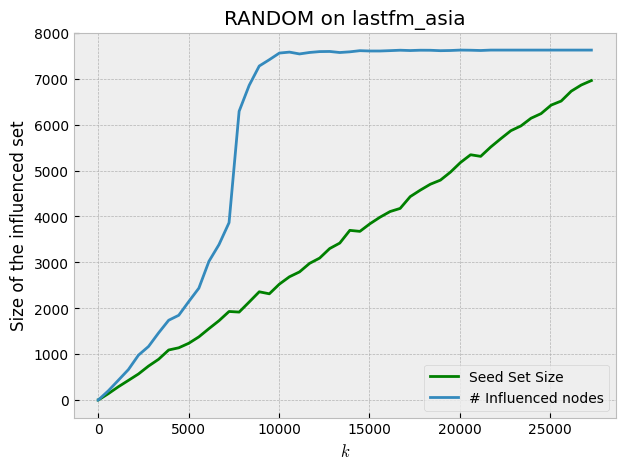

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(ks, ss_sizes, label="Seed Set Size", color="green")
ax.plot(ks, sizes, label="# Influenced nodes")
ax.set_xlabel("$k$")
ax.legend()
ax.set_ylabel("Size of the influenced set")
ax.set_title(f"{SS_STRATEGY.upper()} on {DATASET_NAME}")
ax.grid(True)

In [ ]:
return

SyntaxError: 'return' outside function (3438313781.py, line 1)

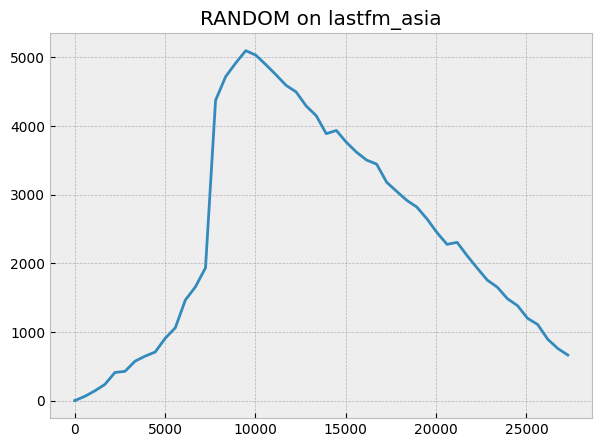

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(ks, np.array(sizes) - np.array(ss_sizes))
ax.set_title(f"{SS_STRATEGY.upper()} on {DATASET_NAME}")
ax.grid(True)

## 5. Save the results

In [ ]:
import pickle

makedirs(f"results/{DATASET_NAME}", exist_ok=True)

with open(f"results/{DATASET_NAME}/{SS_STRATEGY}_{COST_FN}.pkl", "wb") as f:
    pickle.dump({
        "ks": ks,
        "sizes": sizes,
        "ss_sizes": ss_sizes
    }, f)